
# Project: Investigate a Dataset on No-show appointments

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

>  This project explores a dataset on No-show appointments. The datset has information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each of the rows of the datset as described below:
‘ScheduledDay’ tells us on what day the patient set up their appointment.
‘Neighborhood’ indicates the location of the hospital.
‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
'N-show' last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.
What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment? This is the essential question we will try to understand in this project

At the end of this section, I describe the questions that I plan on exploring over the course of the report. 


In [2]:
# Importing all the packages that I intend to use here
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
# magicword for all diagrams to be drawn inline
% matplotlib inline

C:\Users\Manju Goyal\Anaconda3\envs\dataanalysis\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Questions I want to ask

1. Is a particular gender associated with no-show?
2. Were the people reminded of their appointment and did they show up more after the reminder?
3. How does the date the appointment was scheduled matter?

<a id='wrangling'></a>
## Data Wrangling

> In this section of the report, I will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. 

### General Properties

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('noshowappointments.csv')
df.head(2)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No


Now that we have seen the dataset, now let us try to understand datatype, number of unique values in the dataset to understand what type of cleanliness need to be done on the data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


There are no null values. So we don't need to clean that up. Patient ID is a float type so we need to make it integer. Scheduled Day and Appointment Day are object types so they need to be changed to date type. Let us first explore to see all data points are unique.

In [6]:
print(df.columns)
print(df['No-show'].unique())
print(df['SMS_received'].unique())
print(df['Handcap'].unique())
df.nunique()

Index(['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay',
       'AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension',
       'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show'],
      dtype='object')
['No' 'Yes']
[0 1]
[0 1 2 3 4]


PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

> SO we find what unique values in each of the dataframe columns are. Lets proceed to cleaning the data keeping in mind the kind of data we need for the analysis. 

### Data Cleaning
>  Since the datatype in previos section showed that the patient ID is not integer anf also that Scheduled Day and Appointment day are dates and are currently as object type, let us first cure this data


In [7]:
df.PatientId = df.PatientId.astype(int)
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])

Now that data is in the right data type, let us find the time sice apptt and add that as an additional column in our dataframe

In [9]:
df['TimeSinceApptt'] = df['AppointmentDay']-df['ScheduledDay']
print(df.head(5))
df.info()

    PatientId  AppointmentID Gender        ScheduledDay AppointmentDay  Age  \
0 -2147483648        5642903      F 2016-04-29 18:38:08     2016-04-29   62   
1 -2147483648        5642503      M 2016-04-29 16:08:27     2016-04-29   56   
2 -2147483648        5642549      F 2016-04-29 16:19:04     2016-04-29   62   
3 -2147483648        5642828      F 2016-04-29 17:29:31     2016-04-29    8   
4 -2147483648        5642494      F 2016-04-29 16:07:23     2016-04-29   56   

       Neighbourhood  Scholarship  Hipertension  Diabetes  Alcoholism  \
0    JARDIM DA PENHA            0             1         0           0   
1    JARDIM DA PENHA            0             0         0           0   
2      MATA DA PRAIA            0             0         0           0   
3  PONTAL DE CAMBURI            0             0         0           0   
4    JARDIM DA PENHA            0             1         1           0   

   Handcap  SMS_received No-show    TimeSinceApptt  
0        0             0      No 

The column TimeSinceApptt is also showing negative time. The reason this is happening is because the date formats in the Scheduled and appointment day are not the same. So now, let us first change the format of scheduled day so that the formats are same and then again find time since appoitment for each id.

In [10]:
import datetime
# extract just the date and remove time associated in scheduled day
df['ScheduledDay'] = df['ScheduledDay'].dt.date
# change the format back to datetime
df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
df['TimeSinceApptt'] = df['AppointmentDay'] - df['ScheduledDay']
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,TimeSinceApptt
0,-2147483648,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0 days
1,-2147483648,5642503,M,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,0,0,0,0,0,No,0 days
2,-2147483648,5642549,F,2016-04-29,2016-04-29,62,MATA DA PRAIA,0,0,0,0,0,0,No,0 days
3,-2147483648,5642828,F,2016-04-29,2016-04-29,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,0 days
4,-2147483648,5642494,F,2016-04-29,2016-04-29,56,JARDIM DA PENHA,0,1,1,0,0,0,No,0 days


<a id='eda'></a>
## Exploratory Data Analysis

### Is a particular gender associated with more no-shows and what is the impact of age on no-shows?
> Let us explore this here by first finding each of the no-shows by gender and then whether they received an SMS or not

In [11]:
(df.groupby(['Gender'])['No-show']).value_counts()

Gender  No-show
F       No         57246
        Yes        14594
M       No         30962
        Yes         7725
Name: No-show, dtype: int64

In [12]:
df.groupby(['Gender','SMS_received'])['No-show'].value_counts()

Gender  SMS_received  No-show
F       0             No         39764
                      Yes         7874
        1             No         17482
                      Yes         6720
M       0             No         22746
                      Yes         4661
        1             No          8216
                      Yes         3064
Name: No-show, dtype: int64

After doing the value counts, let us now calculate proportion of people who show up at the appointments segregated by gender

In [13]:
(df.query('Gender == "M"')['No-show'] == "Yes").mean()

0.19967947889471915

In [14]:
(df.query('Gender == "F"')['No-show'] == "Yes").mean()

0.20314587973273943

This implies gender alone does not seem to have any correlation with the probability of a person showing up at his/her appointments. Now let us see the proportion of people who showed up segregated by gender and if they received the SMS or not. By this we are seeing if remembering about appintment is affected by gender and technology together.

In [15]:
# proportion of people who are male and received SMS  and no show
RecSMS_Male = (df.query('Gender == "M" & SMS_received == 1')['No-show'] == "Yes").mean()
print(RecSMS_Male)

0.271631205674


In [16]:
# proportion of people who are male and did not received SMS  and no show
NoRecSMS_Male = (df.query('Gender == "M" & SMS_received == 0')['No-show'] == "Yes").mean()
print(NoRecSMS_Male)

0.170066041522


In [17]:
# proportion of people who are female and received SMS  and no show
RecSMS_Female = (df.query('Gender == "F" & SMS_received == 1')['No-show'] == "Yes").mean()
print(RecSMS_Female)

0.277663003058


In [18]:
# proportion of people who are female and received SMS  and no show
NoRecSMS_Female = (df.query('Gender == "F" & SMS_received == 0')['No-show'] == "Yes").mean()
print(NoRecSMS_Male)

0.170066041522


> This is an interesting result. This kind of implies that whether male or female, having received an SMS did not seem to improve the no-show proportion but rather deteriorates it. Let us try to make a bar chart out of this data segregated by gender and having received SMS or not.

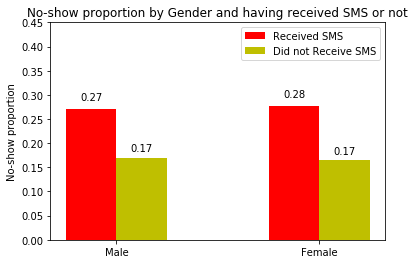

In [19]:
N = 2
# array for people who did receive SMS for both the genders
RecSMS = (RecSMS_Male, RecSMS_Female)

ind = np.arange(N)  # the x locations for the groups
width = 0.25      # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, RecSMS, width, color='r')

# array for people who did not receive SMS for both the genders
NoRecSMS = (NoRecSMS_Male, NoRecSMS_Female)
rects2 = ax.bar(ind + width, NoRecSMS, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('No-show proportion')
ax.set_title('No-show proportion by Gender and having received SMS or not')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Male', 'Female'))
plt.ylim(0,0.45)
ax.legend((rects1[0], rects2[0]), ('Received SMS', 'Did not Receive SMS'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%.2f' % float(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
plt.show()

> The above data shows that having received SMS actually increases the no-show proportion. By all standards this is highly unlikely unless we are not looking at the data from the right angle 

### Does Scholarship help in decreasing the amount of no-shows?

In [19]:
# first create a dataset of peple with no scholarship and then find the people with no shows from them
df[df['Scholarship'] == 0]['No-show'].value_counts()

No     79925
Yes    19741
Name: No-show, dtype: int64

In [20]:
# proportion of people who did not show up even though they had no scholarship/govt funding
(df[df['Scholarship'] == 0]['No-show'] == "Yes").mean()

0.19807155900708365

In [21]:
df[df['Scholarship'] == 1]['No-show'].value_counts()

No     8283
Yes    2578
Name: No-show, dtype: int64

In [22]:
# proportion of people who did not show up and had govt scholarship
(df[df['Scholarship'] == 1]['No-show'] == "Yes").mean()

0.23736304207715681

>The mean number of people who showed up actually increased slightly when we segregated the data based on people having scholarship. This implies not having scholarship does seem to have some impact on peoples showing up on appointments. Having scholarship might be helping people to make appointments at which they do show up. Let us better visualise this data by using a pie chart. 
First lets find percentage of people in each of the sections - had scholarship or not and those that were a no-show or not among them


In [49]:
#The column name No-show has a hyphen and hyphen or spaces do not work in colname for queries 
#thus creating a new column for this query with same data but a different name
df['Noshow'] = df['No-show']
Schol_Noshow = len(df.query('Scholarship ==1 & Noshow == "Yes"'))/len(df) *100
NoSchol_Noshow = len(df.query('Scholarship ==0 & Noshow == "Yes"'))/len(df) *100
Schol_show = len(df.query('Scholarship ==1 & Noshow == "No"'))/len(df) *100
NoSchol_show = len(df.query('Scholarship ==0 & Noshow == "No"'))/len(df) *100

>Now that we have all the required percentages let us draw a pie chart out of the data to visualise how it looks

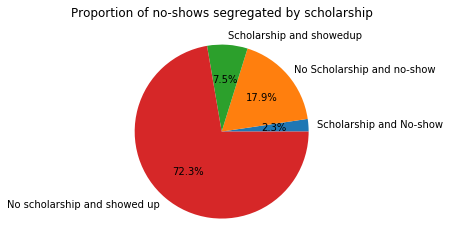

In [51]:
x_list = [Schol_Noshow,NoSchol_Noshow,Schol_show,NoSchol_show]
label_list = ["Scholarship and No-show", "No Scholarship and no-show", "Scholarship and showedup", "No scholarship and showed up"]
plt.axis("equal")
plt.pie(x_list,labels=label_list,autopct="%1.1f%%")
plt.title("Proportion of no-shows segregated by scholarship")
plt.show()

> Pie chart does not seem to be a good chart for this visualization for these variables because it does not make clear whether scholarship helps or not.

### What is the effect of neighborhood on no-shows?

In [53]:
neighbourhoodList = df['Neighbourhood'].unique()
no_nbhd = len(neighbourhoodList)

In [54]:
neighbourhoodratio = np.zeros((no_nbhd))
for i in range(no_nbhd):
   neighbourhoodratio[i]=(df.query('Neighbourhood == @neighbourhoodList[@i]')['No-show'] == "Yes").mean()

> Above, we created a neighbourhood ratio for proportion of noshows in a list corrsponding to different neighbourhoods. Now let us try to visually see how these proportions compare with each other. SInce there is a lot of neighbourhoods, their names will not appear but thats ok since we can study the outleiers later

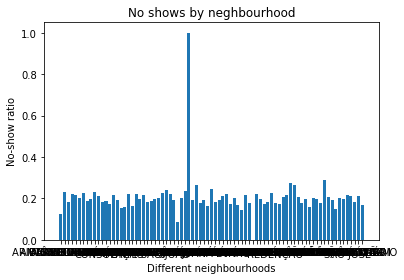

array([ 0.16275471,  0.17080745,  0.17391304,  0.17125749,  0.19571429,
        0.23032714,  0.18845701,  0.17756184,  0.19350474,  0.18295019,
        0.22494172,  0.21037582,  0.15841584,  0.19771242,  0.22292324,
        0.20261438,  0.19944406,  0.2194211 ,  0.19758849,  0.14712154,
        0.19834115,  0.18984061,  0.20999139,  0.17975289,  0.18450185,
        0.20446852,  0.19151194,  0.19164265,  0.20145631,  0.14555256,
        0.17625637,  0.2013634 ,  0.22826087,  0.20786517,  0.26266363,
        0.19110691,  0.21052632,  0.21648963,  0.17707663,  0.26482213,
        0.21085783,  0.22319202,  0.22276029,  0.28918495,  0.23040936,
        0.21985816,  0.2       ,  0.2259663 ,  0.18079888,  0.17223837,
        0.18357488,  0.18589744,  0.16666667,  0.17990654,  0.19634703,
        0.21513002,  0.19702602,  0.1831657 ,  0.21847507,  0.2212766 ,
        0.2047532 ,  0.19469027,  0.24395373,  0.2042042 ,  0.21745351,
        0.23477493,  0.21399549,  0.18064516,  0.27455357,  0.16

In [55]:
plt.bar(neighbourhoodList, neighbourhoodratio)
plt.ylabel('No-show ratio')
plt.xlabel('Different neighbourhoods')
plt.title('No shows by neghbourhood')
 
plt.show()
neighbourhoodratio

>As can be seen from the plot and the value of ratios, almost all of the neighbourhoods have similar ratios other than one neighbourhood which has all no-shows. We can further analyse to confirm how many datasets were in that neighbourhood. This could be because that neighbourhood had just one patient who did not show up but lets verify that in the next step.

In [49]:
# let us find the name of neighbourhood corresponding to 0 and 1 ratio and then the corr. no of patients
name0 = neighbourhoodList[len(neighbourhoodList)-1]
name1 = neighbourhoodList[len(neighbourhoodList)-2]
no_patient0 = len(df.query('Neighbourhood == @name0'))
no_patient1 = len(df.query('Neighbourhood == @name1'))

print('The {} has ratio 0 and number of patients{}'.format(name0, no_patient0))
print('The {} has ratio 1 and number of patients {}'.format(name1, no_patient1))


The PARQUE INDUSTRIAL has ratio 0 and number of patients1
The ILHAS OCEÂNICAS DE TRINDADE has ratio 1 and number of patients 2


>Clearly the small number of patients is not a good dataset to compare the ratios esp for these 2 neighbourhoods

### Do factors such as alcoholism affect the patient's show-up?
> Let us find the proportion of no-shows based on whether they were alcoholic or not

In [50]:
# Effect of alcoholism. segregate the data based on number of people who appear on visits even though alcoholic and calculate relevant mean
df[df['Alcoholism'] == 1]['No-show'].value_counts()

No     2683
Yes     677
Name: No-show, dtype: int64

In [51]:
# now do value count for people who are not alcoholic and show up at appointments
df[df['Alcoholism'] == 0]['No-show'].value_counts()

No     85525
Yes    21642
Name: No-show, dtype: int64

In [52]:
#calculate relevant proportions of no-shows and alcoholic
(df[df['Alcoholism'] == 1]['No-show'] == "Yes").mean()

0.20148809523809524

In [53]:
#calculate relevant proportions of no-shows among non-alcoholic
(df[df['Alcoholism'] == 0]['No-show'] == "Yes").mean()

0.20194649472318904

>From the above analysis on alcoholism, it seems that there is no significant impact of alcoholism on not showing up on appointments. this could be due to small number of people in the dataset on alcoholism too.

### Does the time since Appointment impact no-shows?

In [54]:
# caluclate number of people who did not show up when time since appointment taken was more than 1 day
df.query('TimeSinceApptt > "1 days"')['No-show'].value_counts()

No     47337
Yes    19409
Name: No-show, dtype: int64

In [55]:
# caluclate number of people who did not show up when time since appointment taken was less than 1 day
df.query('TimeSinceApptt <= "1 days"')['No-show'].value_counts()

No     40871
Yes     2910
Name: No-show, dtype: int64

> The number of no-shows is significantly less when the appointment is made within a day. Let us look at the mean number of no-shows for both these cases

In [56]:
# caluclate proportion of people who did not show up when time since appointment taken was more than 1 day
(df.query('TimeSinceApptt > "1 days"')['No-show'] == "Yes").mean()

0.29078896113624786

In [57]:
# caluclate proportion of people who did not show up when time since appointment taken was less than 1 day
(df.query('TimeSinceApptt <= "1 days"')['No-show'] == "Yes").mean()

0.066467188963248894

> From the above analysis, it is clear that people who make appointments well in advance are more likely to not show up on appointments. The next thing to analyse would be to see if this is related to them having received the sms or not. Things to think about would include maybe we can give a reminder call if having forgotten about the appointment is the reason

In [58]:
df['SMS_received'].value_counts()

0    75045
1    35482
Name: SMS_received, dtype: int64

Not a whole lot of patients have received an SMS. Let us explore more to understand if there is any correlation between people havign received SMS and no-shows

In [59]:
# calculate proportion of people who had not received an SMS and were a no-show
(df.query('SMS_received == 0')['No-show'] == "Yes").mean()

0.16703311346525418

In [60]:
# calculate proportion of people who had received an SMS and were a no-show
(df.query('SMS_received == 1')['No-show'] == "Yes").mean()

0.27574544839637

> SMS having received taken individually does not seem to help decreasing the number of no-shows. Let us see it combined with time since appointment. Let us segregate the number of people who made an appointment more than a day ago and received an SMS and those that don't and calculate individual proportions of people who showed up among them.

In [73]:
# create a dataset of peopel with time since appointment greater than 1 day since we saw they are more likely to not show up and those that have received an SMS
NoRecSMS_Great= (df.query('SMS_received == 0 & TimeSinceApptt > "1 days"')['No-show'] == "Yes").mean()

# create a dataset of peopel with time since appointmentless than 1 day since we saw they are more likely to not show up and those that have received an SMS
NoRecSMS_Less= (df.query('SMS_received == 0 & TimeSinceApptt <= "1 days"')['No-show'] == "Yes").mean()

print (NoRecSMS_Great, NoRecSMS_Less)

0.307862077789 0.0664671889632


In [75]:
# now calculate proportion of people with longer time since appointment and having received SMS and calculate proportion of noshows
RecSMS_Great=(df.query('SMS_received == 1 & TimeSinceApptt > "1 days"')['No-show'] == "Yes").mean()

# now calculate proportion of people with lesser time since appointment and having received SMS and calculate proportion of noshows
RecSMS_Less=(df.query('SMS_received == 1 & TimeSinceApptt <= "1 day"')['No-show'] == "Yes").mean()

print (RecSMS_Great,RecSMS_Less)


0.275745448396 nan


> Above results indicate that there is no data with people who have received the SMS for appointment reminder if time since appointment is less than 1 day. Perhaps the system send SMS to remind not at the time of booking but the dataset does not make that clear

> Having received an SMS seems to slightly increase the chance of showing up for people who have taken an appointment more than a day before the actual appointment day. We should definitely consider sending more frequent reminder since it seems reminding might help decrease the no shows. Let us draw this as a grouped/nested bar plot.

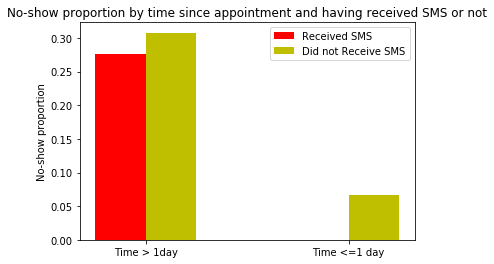

In [79]:
"""
========
Barchart
========

A bar plot
"""

N = 2
# array for people who did receive SMS for both the chunks time since appointment greater than 1 day and less than 1 day
RecSMS = (RecSMS_Great, RecSMS_Less)

ind = np.arange(N)  # the x locations for the groups
width = 0.25      # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(ind, RecSMS, width, color='r')

# array for people who did not receive SMS for both the chunks time since appointment greater than 1 day and less than 1 day
NoRecSMS = (NoRecSMS_Great, NoRecSMS_Less)
rects2 = ax.bar(ind + width, NoRecSMS, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('No-show proportion')
ax.set_title('No-show proportion by time since appointment and having received SMS or not')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('Time > 1day', 'Time <=1 day'))

ax.legend((rects1[0], rects2[0]), ('Received SMS', 'Did not Receive SMS'))
plt.show()

> The above chart shows two important things. Proportion of no-shows is much less if people took appointment less than a day ago. For people who took appointment longer than a day back, no-show proportion is less ofr people who received SMS. So receiving an SMS overall does help. It does not show the proportion of people who received SMS and who took appointment less than a day ago. If we analyze this further, we will realize that the issue with the above chart is becuase no-one with an appointment less than 1 day will receive an SMS. This was not clear in the dataset but a query to find people who received SMS whose appointment was scheduled less than a day ago gives null value

<a id='conclusions'></a>
## Conclusions

> The above data suggests that the following factors are really important for patients to show up at the appointments:
1 Time since appointment definitely is an important factor when it comes to showing up for an appoitnment. A person who makes an appoitnment within a day of appointment is more likely to come to the appointment.
2 Receiving an SMS reminder does helps to slightly increase the chance of a person showing up at the appointment. 
3 Being registered with a welfare program, scholarship seems to help in showing up. Maybe, affordability is an issue for people who do not show up but not enough data is avaialbel to analyse this further, If we had data on income of people we could analyse it further.
Data suggests that gender, alcoholism and neighbourhood do not impact the no-shows
Data does not tell when the SMS was received and if there are ways to increase the SMS receival rate. More data on such information will help us conclude better on what can be done to incraese the patients that show up at the appointments. 
